<a href="https://colab.research.google.com/github/sundaysvnset/Final-Project-Pengolahan-Sinyal-Group-1-/blob/main/_PSB_FinalProject_Group1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

# **Breast Cancer Severity Classification and Subtype Prediction from Mammographic Images for Treatment Recommendation**  

**Group 1 | Pengolahan Sinyal Biomedis**  

Rufaida Kariemah (2206031561)  
Annisa Rahmah (2206032412)  
Shofiyah (2206060662)  

</div>

---

## **Tentang Projek**  
*Kanker payudara menyumbang ~25% kasus kanker baru pada perempuan global (WHO, 2023). Proyek ini mengembangkan sistem cascaded deep learning berbasis EfficientNet B0 untuk:*  
1. **Klasifikasi Keparahan**: Menggunakan dataset INbreast (410 citra DICOM) dengan skor BI-RADS  
2. **Prediksi Subtipe Molekuler**: Menggunakan subset CMMD2 (2,956 citra) dengan 4 subtipe  
3. **Rekomendasi Terapi**: Pemetaan subtipe ke pedoman klinis NCCN 2023  

---

## **Dataset yang digunakan**
**A. INbreast Dataset**
- Jenis: Dataset mammografi digital full-field (FFDM)
- Jumlah kasus: 115 kasus (89 pasien)
- Jumlah gambar: 410 citra (format DICOM (.dcm))

**Isi/Label:**

- Anotasi BI-RADS score (0 sampai 5)
- Anotasi klasifikasi lesi: normal, jinak (benign), ganas (malignant)
- Informasi tambahan: jenis lesi (massa, mikrokalsifikasi, asimetri, distorsi arsitektur, dll)
- Anotasi lesi berbentuk maske segmenasi (jika digunakan, dalam format XML dari software Mammo Viewer)

Tujuan dalam proyek: Klasifikasi tahap awal (apakah kanker dan tingkat keparahannya)

**B. CMMD (Chinese Mammography Database)**
- Versi digunakan: CMMD2
- Jumlah citra: 2,956 citra (dari 1,177 pasien)
- Jenis: Citra mammografi 2D (format DICOM)

**Isi/Label:**

- Informasi diagnosis histopatologi
- Subtipe molekuler kanker:
- Luminal A
- Luminal B
- HER2-positive
- Triple-negative
- Metadata pasien: usia, stadium, status ER/PR/HER2

Tujuan dalam proyek: Prediksi subtipe molekuler untuk mendukung rekomendasi pengobatan

### **INbreast dan CMMD2**

| **Elemen**              | **INbreast Dataset**                         | **CMMD2 Dataset**                                |
|-------------------------|----------------------------------------------|--------------------------------------------------|
| **Format gambar**       | DICOM (.dcm)                                 | DICOM (.dcm)                                     |
| **Label klasifikasi**   | BI-RADS, jinak/ganas/normal                  | Subtipe molekuler kanker                         |
| **Anotasi tambahan**    | XML (opsional, mask segmenasi)              | Metadata (usia, status ER/PR/HER2)               |
| **Dimensi gambar**      | Resolusi tinggi (>3000x4000 pixel)           | Resolusi sedang-tinggi (~2560x3328 pixel)        |



# **CORE**

In [ ]:
!pip install numpy==1.26.4 --force-reinstall --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 291.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import numpy as np
print("Versi NumPy sekarang:", np.__version__)

Versi NumPy sekarang: 1.26.4


In [ ]:
# Core
!pip install -q pandas matplotlib seaborn scikit-learn

# PyTorch + EfficientNet (via timm)
!pip uninstall -y torchvision
!pip install torchvision==0.15.2 --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q timm

# DICOM Processing
!pip install -q pydicom

# Image preprocessing
!pip install -q opencv-python-headless pillow albumentations

# Progress bar (optional)
!pip install -q tqdm

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import cv2
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.15.2%2Bcu118-cp311-cp311-linux_x86_64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu118/torch-2.0.1%2Bcu118-cp311-cp311-linux_x86_64.whl (2267.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.0.1+cu118 which is incompatible.


# **DATA LOADING**
### INBREAST DATASET

In [ ]:
# Upload kaggle.json dulu
from google.colab import files
files.upload()  # pilih kaggle.json

# Setup credential
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI
!pip install -q kaggle

# Download dataset
!kaggle datasets download -d ramanathansp20/inbreast-dataset

# Unzip dataset
!unzip -q inbreast-dataset.zip -d inbreast

import zipfile

with zipfile.ZipFile("inbreast-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("inbreast")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ramanathansp20/inbreast-dataset
License(s): unknown
100% 1.93G/1.93G [00:10<00:00, 246MB/s]
100% 1.93G/1.93G [00:10<00:00, 196MB/s]


# **DATA INSPECTION**

In [ ]:
#Visualize Structure of File

import os

# Ganti "inbreast" jika folder hasil ekstraksi kamu beda
base_path = "inbreast"

for root, dirs, files in os.walk(base_path):
    print(f"\n📂 Folder: {root}")
    for file in files[:5]:  # tampilkan max 5 file per folder
        print("  └──", file)


📂 Folder: inbreast

📂 Folder: inbreast/INbreast Release 1.0
  └── inbreast.pdf
  └── INbreast.csv
  └── INbreast.xls
  └── README.txt

📂 Folder: inbreast/INbreast Release 1.0/PectoralMuscle

📂 Folder: inbreast/INbreast Release 1.0/PectoralMuscle/Pectoral Muscle XML
  └── 53581237_muscle.xml
  └── 26933859_muscle.xml
  └── 50993895_muscle.xml
  └── 24055328_muscle.xml
  └── 53587454_muscle.xml

📂 Folder: inbreast/INbreast Release 1.0/PectoralMuscle/Pectoral Muscle ROI
  └── 24055752_muscle.roi
  └── 53586388_muscle.roi
  └── 50996945_muscle.roi
  └── 22670878_muscle.roi
  └── 22613848_muscle.roi

📂 Folder: inbreast/INbreast Release 1.0/AllDICOMs
  └── 51048918_f3e93e889a7746f0_MG_R_ML_ANON.dcm
  └── 22580732_fe7d005dcbbfb46d_MG_L_ML_ANON.dcm
  └── 53586960_809e3f43339f93c6_MG_L_ML_ANON.dcm
  └── 50997277_9054942f7be52dd9_MG_L_CC_ANON.dcm
  └── 53587572_11e6732579acf692_MG_L_ML_ANON.dcm

📂 Folder: inbreast/INbreast Release 1.0/AllROI
  └── 22579730.roi
  └── 20587836.roi
  └── 22670278.

Dalam folder inbreast induk terdiri dari 5 folder lainnya juga README, pdf, xls, dan csv. Di mana pdf merupakan technical report atau publikasi ilmiah dari dataset inbreast. Kemudian xls dan csv merupakan data dari keseluruhan pasien (database) dengan variable patient id, age, laterality, view, acquisition date, file name, ACR, Bi-Rads.

Kelima folder di dalam folder induk ini terdiri dari file DICOM yang lengkap dalam folder `AllDICOMs`, dengan nama file mencakup ID pasien anonim untuk mengelompokkan citra dan menghubungkannya dengan laporan medis. Dua folder anotasi manual tersedia dalam format: `.roi` dan `.xml`. Folder `MedicalReports` berisi laporan medis yang sesuai, diberi nama berdasarkan ID pasien anonim. Sementara itu, folder `PectoralMuscle` memuat anotasi batas otot pektoral secara manual.


In [ ]:
#Check Format File and Image

from collections import Counter

all_files = []
for root, _, files in os.walk(base_path):
    for f in files:
        all_files.append(os.path.join(root, f))

ext_counter = Counter([os.path.splitext(f)[-1].lower() for f in all_files])
print("🔍 Jumlah file berdasarkan ekstensi:")
print(ext_counter)

🔍 Jumlah file berdasarkan ekstensi:
Counter({'.xml': 544, '.roi': 544, '.dcm': 410, '.txt': 118, '.m': 2, '.pdf': 1, '.csv': 1, '.xls': 1})


Jumlah file dalam format :
<br>.roi : 544
<br>.xml : 544
<br>.dcm : 410
<br>.txt : 188
<br>.m : 2
<br>.pdf : 1
<br>.xls : 1
<br>.csv : 1



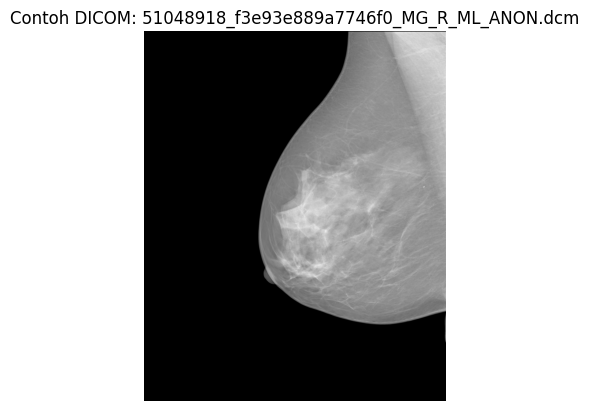

In [ ]:
#Visualize One Image from DICOM

# Temukan file DICOM pertama
sample_dcm_path = [f for f in all_files if f.endswith('.dcm')][0]

# Baca file DICOM
dcm = pydicom.dcmread(sample_dcm_path)

# Tampilkan gambar
plt.imshow(dcm.pixel_array, cmap='gray')
plt.title(f"Contoh DICOM: {os.path.basename(sample_dcm_path)}")
plt.axis('off')
plt.show()

In [ ]:
#Check Resolution of All Images

dcm_sizes = []

for path in all_files:
    if path.endswith(".dcm"):
        try:
            dcm = pydicom.dcmread(path)
            shape = dcm.pixel_array.shape
            dcm_sizes.append(shape)
        except Exception as e:
            print(f"Gagal baca: {path} — {e}")

# Buat DataFrame dan tampilkan statistik
df_dcm_sizes = pd.DataFrame(dcm_sizes, columns=["height", "width"])
print("Statistik ukuran gambar DICOM:")
print(df_dcm_sizes.describe())

Statistik ukuran gambar DICOM:
            height        width
count   410.000000   410.000000
mean   3635.931707  2872.819512
std     371.902918   377.806139
min    3328.000000  2560.000000
25%    3328.000000  2560.000000
50%    3328.000000  2560.000000
75%    4084.000000  3328.000000
max    4084.000000  3328.000000


In [ ]:
#Check Database

# Path ke file CSV
csv_path = "inbreast/INbreast Release 1.0/INbreast.csv"

# Baca file CSV, delimiter-nya semicolon
df = pd.read_csv(csv_path, delimiter=';')

# Tampilkan nama kolom
print("📄 Kolom yang tersedia:")
print(df.columns)

# Tampilkan beberapa baris awal
print("\n🔍 Sampel isi data:")
print(df.head())

# Hitung dan tampilkan distribusi Bi-Rads
print("\n📊 Distribusi Bi-Rads (severity level):")
birads_counts = df['Bi-Rads'].value_counts(dropna=True).sort_index()
print(birads_counts)

# Hitung total entri dengan nilai Bi-Rads
total_birads = birads_counts.sum()
print(f"\n📌 Total entri dengan Bi-Rads: {total_birads}")

# Hitung jumlah entri yang kosong
missing_birads = df['Bi-Rads'].isna().sum()
print(f"❗ Jumlah entri tanpa Bi-Rads (NaN): {missing_birads}")

📄 Kolom yang tersedia:
Index(['Patient ID', 'Patient age', 'Laterality', 'View', 'Acquisition date',
       'File Name', 'ACR', 'Bi-Rads'],
      dtype='object')

🔍 Sampel isi data:
  Patient ID Patient age Laterality View  Acquisition date  File Name ACR  \
0    removed     removed          R   CC            201001   22678622   4   
1    removed     removed          L   CC            201001   22678646   4   
2    removed     removed          R  MLO            201001   22678670   4   
3    removed     removed          L  MLO            201001   22678694   4   
4    removed     removed          R   CC            201001   22614074   2   

  Bi-Rads  
0       1  
1       3  
2       1  
3       3  
4       5  

📊 Distribusi Bi-Rads (severity level):
Bi-Rads
1      67
2     220
3      23
4a     13
4b      8
4c     22
5      49
6       8
Name: count, dtype: int64

📌 Total entri dengan Bi-Rads: 410
❗ Jumlah entri tanpa Bi-Rads (NaN): 0


In [ ]:
#Cross Check Image and Database

# Path folder gambar
dicom_dir = "inbreast/INbreast Release 1.0/AllDICOMs"
all_dicom_files = [f for f in os.listdir(dicom_dir) if f.endswith(".dcm")]

# Ambil Patient ID dari CSV
csv_ids = df['File Name'].astype(str).tolist()

# Cocokkan berdasarkan awalan
matched_files = []
for file in all_dicom_files:
    for pid in csv_ids:
        if file.startswith(pid + "_"):
            matched_files.append((pid, file))
            break

print(f"Jumlah file yang cocok berdasarkan Patient ID: {len(matched_files)} / {len(csv_ids)}")

Jumlah file yang cocok berdasarkan Patient ID: 410 / 410


#INbreast Data Engineering (80%)

##Konversi DICOM ke PNG

In [ ]:
import os
import pydicom
import numpy as np
from PIL import Image
from tqdm import tqdm

# Tentukan path input dan output
dicom_dir = "inbreast/INbreast Release 1.0/AllDICOMs/"
png_dir = "inbreast_png/"

# Buat folder output jika belum ada
os.makedirs(png_dir, exist_ok=True)

# Ambil daftar semua file DICOM
dicom_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]

print(f"Memulai konversi {len(dicom_files)} file DICOM ke PNG...")

# Loop untuk setiap file DICOM
for filename in tqdm(dicom_files):
    # Path lengkap ke file DICOM
    dicom_path = os.path.join(dicom_dir, filename)

    # Baca file DICOM
    dcm = pydicom.dcmread(dicom_path)

    # Ambil pixel array dari data DICOM
    pixels = dcm.pixel_array

    # Normalisasi pixel ke rentang 0-255 agar bisa disimpan sebagai gambar 8-bit
    # Ini langkah penting agar kontras gambar tetap baik
    pixels = (pixels / pixels.max()) * 255.0

    # Konversi tipe data ke unsigned integer 8-bit
    pixels = pixels.astype(np.uint8)

    # Buat gambar dari array piksel menggunakan Pillow (PIL)
    img = Image.fromarray(pixels)

    # Buat nama file baru dengan ekstensi .png
    new_filename = os.path.splitext(filename)[0] + '.png'

    # Path lengkap untuk menyimpan file PNG baru
    png_path = os.path.join(png_dir, new_filename)

    # Simpan gambar sebagai file PNG
    img.save(png_path)

print(f"\nKonversi selesai. Semua {len(dicom_files)} gambar telah disimpan di folder '{png_dir}'.")

Memulai konversi 410 file DICOM ke PNG...


100%|██████████| 410/410 [04:09<00:00,  1.65it/s]


Konversi selesai. Semua 410 gambar telah disimpan di folder 'inbreast_png/'.


Setelah mengecek informasi dari dataset, konversi gambar terlebih dahulu dilakukan. Yaitu mengubah file DICOM menjadi PNG. Hal ini dilakukan guna mempermudah proses *resizing, augmentsi* dan data *loading* ke model deep learning. Kode tersebut akan membuat folder baru bernama ``` inbreast_png``` untuk menyimpan gambar hasil konversi. Kemudian setiap file ```.dcm``` akan dibaca dan diubah data pikselnya menjadi format gambar standar. Terakhir, file akan disimpan dalam bentuk ```.png``` dalam folder yang sudah dibuat sebelumnya.



##Resizing Gambar

In [ ]:
import os
from PIL import Image
from tqdm import tqdm

# Tentukan path folder input (hasil dari langkah sebelumnya) dan output
png_dir = "inbreast_png/"
resized_dir = "inbreast_resized/"

# Ukuran target baru untuk gambar (ini adalah hyperparameter, bisa diubah)
TARGET_SIZE = (512, 512)

# Buat folder output jika belum ada
os.makedirs(resized_dir, exist_ok=True)

# Ambil daftar semua file PNG dari folder input
png_files = [f for f in os.listdir(png_dir) if f.endswith('.png')]

print(f"Memulai resizing {len(png_files)} gambar ke ukuran {TARGET_SIZE}...")

# Loop untuk setiap file PNG
for filename in tqdm(png_files):
    # Path lengkap ke file PNG input
    img_path = os.path.join(png_dir, filename)

    # Buka gambar
    img = Image.open(img_path)

    # Resize gambar. Kita pakai LANCZOS karena kualitasnya bagus untuk downscaling.
    img_resized = img.resize(TARGET_SIZE, Image.Resampling.LANCZOS)

    # Path lengkap untuk menyimpan file PNG baru yang sudah di-resize
    resized_path = os.path.join(resized_dir, filename)

    # Simpan gambar yang sudah di-resize
    img_resized.save(resized_path)

print(f"\nResizing selesai. Semua {len(png_files)} gambar telah disimpan di folder '{resized_dir}' dengan ukuran {TARGET_SIZE}.")

Memulai resizing 410 gambar ke ukuran (512, 512)...


100%|██████████| 410/410 [00:53<00:00,  7.63it/s]


Resizing selesai. Semua 410 gambar telah disimpan di folder 'inbreast_resized/' dengan ukuran (512, 512).


Proses *resizing* diperlukan karena model *deep learning* membutuhkan input gambar dengan ukuran yang sama persis. Semua gambar PNG yang sudah diconvert sebelumnya diambil dan diubah ukurannya menjadi ukuran standar, yaitu dalam konteks ini menjadi 512x512 piksel. Kemudian keseluruhan gambar yang sudah di*resize* tersebut akan diletakkan di dalam folder ```inbreast_resized```.

##Menyiapkan Label dan Membagi Dataset

Setelah dilakukan *resize*, tahapan selanjutnya adalah mempersiapkan label/anotasi, di mana daftar penghubung dari setiap gambar yang telah di-*resize* akan dibuat berdasarkan label klasifikasinya. Dalam hal ini berdasarkan skor BI-RADS. Juga membagi dataset menjadi *set training, validation,* dan *test* secara proporsional. Kode di bawah akan membaca kembali file pusat untuk mengambil informasi. Kemudian sebuah dataframe dibuat yang berisi path ke setiap gambar yang sudah di-*resize* serta diberikan label BI-RADS yang sesuai. Dataframe yang baru dibuat tersebut akan dibagi menjadi data *training* dan data *testing* dengan perbandingan 80:20. Pembagian ini dibagi secara *stratified* berdasarkan label BI-RADS untuk memastikan distribusi kelas di kedua set seimbang, sehingga tidak terjadi tumpang-tindih.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# --- 1. Menyiapkan Label untuk Setiap Gambar ---

# Baca lagi file CSV untuk mendapatkan label
csv_path = "inbreast/INbreast Release 1.0/INbreast.csv"
df_labels = pd.read_csv(csv_path, delimiter=';')

# Ambil hanya kolom yang kita perlukan: File Name dan Bi-Rads
df_labels = df_labels[['File Name', 'Bi-Rads']]

# Path ke folder gambar yang sudah di-resize
resized_dir = "inbreast_resized/"

# Buat daftar path lengkap ke setiap gambar resized
image_files = [os.path.join(resized_dir, f) for f in os.listdir(resized_dir) if f.endswith('.png')]

# Buat DataFrame baru untuk menyimpan path gambar dan labelnya
data = []
for img_path in image_files:
    # Ambil nama file tanpa ekstensi untuk mencocokkan dengan 'File Name' di CSV
    # Nama file PNG kita formatnya: NAMAFILEASLI_....png, jadi kita split berdasarkan '_'
    base_name = os.path.basename(img_path).split('_')[0]

    # Cari label BI-RADS yang sesuai di df_labels
    label_info = df_labels[df_labels['File Name'] == int(base_name)]

    if not label_info.empty:
        # Ambil nilai Bi-Rads
        bi_rads_label = label_info['Bi-Rads'].iloc[0]
        data.append({'image_path': img_path, 'Bi-Rads': bi_rads_label})

# Konversi list of dictionaries menjadi DataFrame
df_master = pd.DataFrame(data)

print("Master DataFrame berhasil dibuat:")
print(df_master.head())
print(f"\nTotal data yang akan dibagi: {len(df_master)} gambar")
print("\nDistribusi kelas BI-RADS sebelum dibagi:")
print(df_master['Bi-Rads'].value_counts().sort_index())


# --- 2. Membagi Dataset (Training & Testing) ---

# Pisahkan fitur (path gambar) dan target (label Bi-Rads)
X = df_master['image_path']
y = df_master['Bi-Rads']

# Bagi data menjadi 80% training dan 20% testing
# 'stratify=y' memastikan distribusi kelas di train dan test sama
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42, # 'random_state' agar hasil pembagiannya selalu sama setiap kali di-run
    stratify=y
)

# Gabungkan kembali menjadi DataFrame train dan test untuk kemudahan
df_train = pd.DataFrame({'image_path': X_train, 'Bi-Rads': y_train})
df_test = pd.DataFrame({'image_path': X_test, 'Bi-Rads': y_test})

print("\n--- Hasil Pembagian Dataset ---")
print(f"Jumlah data training: {len(df_train)}")
print(f"Jumlah data testing: {len(df_test)}")

print("\nDistribusi kelas BI-RADS di data training:")
print(df_train['Bi-Rads'].value_counts().sort_index())

print("\nDistribusi kelas BI-RADS di data testing:")
print(df_test['Bi-Rads'].value_counts().sort_index())

Master DataFrame berhasil dibuat:
                                          image_path Bi-Rads
0  inbreast_resized/50998032_66adfbb4f19c76d2_MG_...       2
1  inbreast_resized/20588046_024ee3569b2605dc_MG_...       6
2  inbreast_resized/53581379_b231a8ba4dd4214f_MG_...       1
3  inbreast_resized/53582567_3e73f1c0670cfb0a_MG_...       1
4  inbreast_resized/27829215_fbb55bf7fff48540_MG_...       1

Total data yang akan dibagi: 410 gambar

Distribusi kelas BI-RADS sebelum dibagi:
Bi-Rads
1      67
2     220
3      23
4a     13
4b      8
4c     22
5      49
6       8
Name: count, dtype: int64

--- Hasil Pembagian Dataset ---
Jumlah data training: 328
Jumlah data testing: 82

Distribusi kelas BI-RADS di data training:
Bi-Rads
1      54
2     176
3      19
4a     10
4b      6
4c     18
5      39
6       6
Name: count, dtype: int64

Distribusi kelas BI-RADS di data testing:
Bi-Rads
1     13
2     44
3      4
4a     3
4b     2
4c     4
5     10
6      2
Name: count, dtype: int64


Setelah dilakukan *resize*, tahapan selanjutnya adalah mempersiapkan label/anotasi, di mana daftar penghubung dari setiap gambar yang telah di-*resize* akan dibuat berdasarkan label klasifikasinya. Dalam hal ini berdasarkan skor BI-RADS. Juga membagi dataset menjadi *set training, validation,* dan *test* secara proporsional. Kode di bawah akan membaca kembali file pusat untuk mengambil informasi. Kemudian sebuah dataframe dibuat yang berisi path ke setiap gambar yang sudah di-*resize* serta diberikan label BI-RADS yang sesuai. Dataframe yang baru dibuat tersebut akan dibagi menjadi data *training* dan data *testing* dengan perbandingan 80:20. Pembagian ini dibagi secara *stratified* berdasarkan label BI-RADS untuk memastikan distribusi kelas di kedua set seimbang, sehingga tidak terjadi tumpang-tindih.

Keseluruhan data tersebut telah berhasil membuat label pada keseluruhan gambar, 410 gambar. Sebelum dibagi, BI-RADS *imbalanced* di mana Bi-Rads 2 lebih banyak datanya sebanyak 220 gambar dibandingkan Bi-Rads 6 yang hanya memiliki 8 gambar. Sehingga perlu dibagi secara merata. Sekarang data sudah terbagi dengan rata. Data training berisi 328 gambar, data testing berisi 82 gambar. Pembagian persentase di setiap kelas Bi-Rads terbagi dengan rata, sehingga akan representatif.

##PyTorch Custom Dataset dan DataLoader

Pemetaan Label BI-RADS ke Angka:
{'1': 0, '2': 1, '3': 2, '4a': 3, '4b': 4, '4c': 5, '5': 6, '6': 7}

Berhasil membuat DataLoader!
Jumlah batch di train_loader: 21
Jumlah batch di test_loader: 6

Ukuran satu batch gambar: torch.Size([16, 3, 512, 512])
Ukuran satu batch label: torch.Size([16])


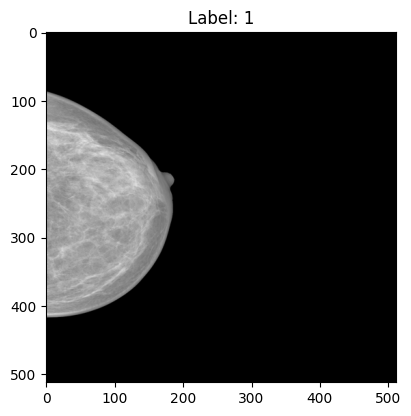

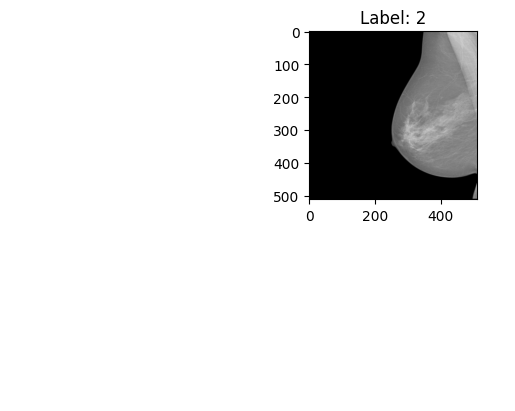

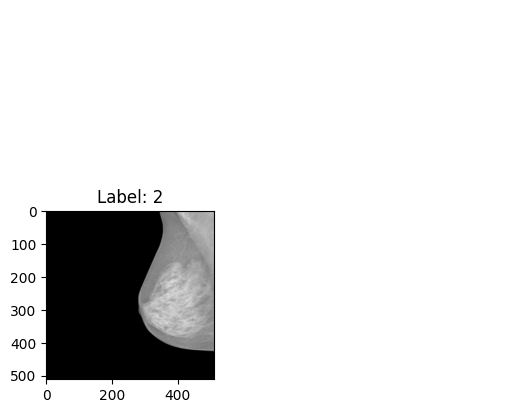

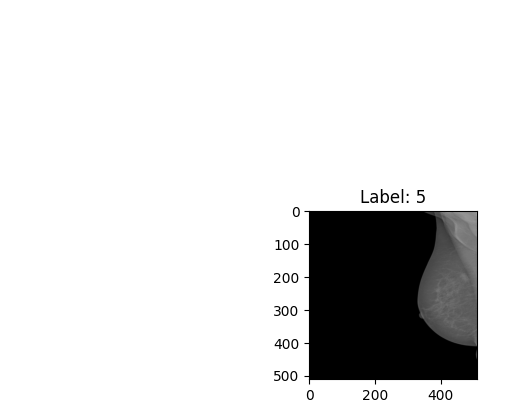

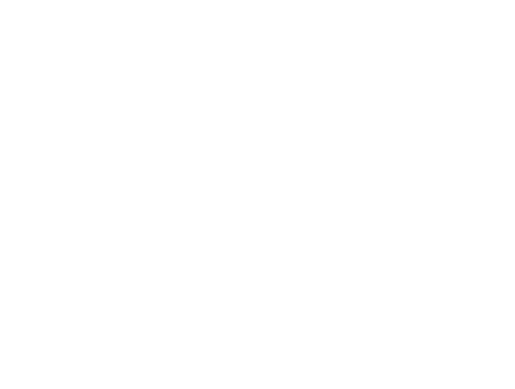

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np # Import numpy
from PIL import Image # Import the Image class

# --- 1. Pemetaan Label (Label Mapping) ---
# Model hanya mengerti angka, jadi kita ubah label BI-RADS ke format angka.
# Kita urutkan dulu label unik yang ada di data kita.
unique_labels = sorted(df_master['Bi-Rads'].unique())
label_map = {label: i for i, label in enumerate(unique_labels)}
# Juga buat pemetaan sebaliknya untuk nanti saat visualisasi
inverse_label_map = {i: label for label, i in label_map.items()}

print("Pemetaan Label BI-RADS ke Angka:")
print(label_map)


# --- 2. Definisikan Transformasi Gambar ---
# Model pretrained di PyTorch biasanya dilatih dengan gambar 3 channel (RGB)
# dan dinormalisasi dengan mean & std dari ImageNet.
# Kita akan pakai transformasi ini.
data_transforms = transforms.Compose([
    transforms.ToTensor(), # Mengubah gambar menjadi PyTorch Tensor (nilai 0-1)
    # Normalisasi dengan mean dan std ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# --- 3. Membuat Kelas Custom Dataset ---
class INbreastDataset(Dataset):
    def __init__(self, dataframe, label_mapping, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame yang berisi path gambar dan label.
            label_mapping (dict): Dictionary untuk memetakan label string ke integer.
            transform (callable, optional): Transformasi yang akan diaplikasikan pada gambar.
        """
        self.df = dataframe
        self.transform = transform
        self.label_map = label_mapping

    def __len__(self):
        # Mengembalikan total jumlah data
        return len(self.df)

    def __getitem__(self, idx):
        # Mengambil satu data sample berdasarkan index

        # Ambil path gambar dan label dari dataframe
        img_path = self.df.iloc[idx]['image_path']
        bi_rads_label_str = self.df.iloc[idx]['Bi-Rads']

        # Buka gambar. Konversi ke "RGB" karena model pretrained butuh input 3 channel
        image = Image.open(img_path).convert("RGB")

        # Ubah label string ke integer menggunakan map yang sudah kita buat
        label = self.label_map[bi_rads_label_str]

        # Aplikasikan transformasi pada gambar
        if self.transform:
            image = self.transform(image)

        return image, label


# --- 4. Membuat Instance Dataset dan DataLoader ---

# Buat dataset untuk training dan testing
train_dataset = INbreastDataset(df_train, label_map, transform=data_transforms)
test_dataset = INbreastDataset(df_test, label_map, transform=data_transforms)

# Buat DataLoader
# DataLoader akan mengatur data ke dalam batch dan mengacaknya (untuk training)
BATCH_SIZE = 16 # Kamu bisa coba ubah-ubah ukuran batch ini nanti
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nBerhasil membuat DataLoader!")
print(f"Jumlah batch di train_loader: {len(train_loader)}")
print(f"Jumlah batch di test_loader: {len(test_loader)}")


# --- 5. (Opsional tapi PENTING) Visualisasi Satu Batch untuk Pengecekan ---
# Kita cek apakah data loader sudah bekerja dengan benar

# Ambil satu batch dari train_loader
images, labels = next(iter(train_loader))

print(f"\nUkuran satu batch gambar: {images.shape}") # Harusnya [Batch_Size, Channel, Height, Width]
print(f"Ukuran satu batch label: {labels.shape}")

# Fungsi untuk menampilkan gambar (perlu denormalisasi)
def imshow(inp, title=None):
    """Menampilkan gambar Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Ambil 4 gambar pertama dari batch untuk ditampilkan
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    # Ambil label asli (string) dari label angka
    title = f"Label: {inverse_label_map[labels[i].item()]}"
    imshow(images[i], title=title)
    plt.axis('off')

PyTorch yang akan digunakan membutuhkan data disajikan dalam format khusus agar efisien saat melakukan *training*. Custom dataset berguna untuk memberi tahu PyTorch cara mengambil satu buah data yang berisi satu gambar dan satulabel, dan bagaimana cara memprosesnya. Contohnya dengan mengubah gambar menjadi tensor. Sedangkan data loader merupakan pembungkus dari dataset yang bertugas untuk mengambil data, kemudian mengaturnya ke dalam kelompok data berupa batch dan mengacaknya setiap epoch agar model dapat belajar lebih baik. Selain itu, gambar akan diubah kembali menjadi format Tensor PyTorch dan dinormalisasi. Juga pemetaan label BI-RADS yang masih berupa teks, menjadi angka agar dapat diproses oleh model.

Setelah dijalankan, didapatkan tabel BI-RADS yang memetakan angka baru, info dataloader berupa jumlah batch yang berhasil dibuat untuk data training dan testing. Juga terdapat 4 contoh gambar dari data training beserta label aslinya. Untuk memverifikasi seluruh pipeline data sudah berjalan dengan baik.

#Modeling Pipeline - 1 (INbreast)

##Preparation Model & Training

In [ ]:
import torch.nn as nn
import torch.optim as optim

# --- 1. Menyiapkan Perangkat (Device) ---
# Cek apakah ada GPU yang tersedia (di Colab, biasanya ada), jika tidak, pakai CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {device}")


# --- 2. Menginisialisasi Model ---

# Tentukan jumlah kelas output. Ini adalah jumlah label BI-RADS unik yang kita punya.
# Kita ambil dari `label_map` yang sudah dibuat sebelumnya.
num_classes = len(label_map)

# Load model pretrained EfficientNet B0 menggunakan library timm
# pretrained=True berarti kita mengambil bobot yang sudah dilatih di ImageNet
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)

# Pindahkan model ke perangkat yang aktif (GPU/CPU)
model.to(device)


# --- 3. Menentukan Loss Function dan Optimizer ---

# Loss Function:
# Untuk masalah klasifikasi multi-kelas seperti ini, CrossEntropyLoss adalah pilihan yang standar dan bagus.
# Dia akan mengukur seberapa jauh prediksi model dari label yang sebenarnya.
criterion = nn.CrossEntropyLoss()

# Optimizer:
# Kita pakai AdamW, ini adalah versi perbaikan dari optimizer Adam yang populer.
# Tugasnya adalah menyesuaikan bobot-bobot di dalam model agar loss-nya semakin kecil.
# 'lr' adalah learning rate, yaitu seberapa besar langkah 'perbaikan' yang diambil setiap kali.
optimizer = optim.AdamW(model.parameters(), lr=1e-4)


print("\nModel, Loss Function, dan Optimizer berhasil disiapkan!")
# Tampilkan arsitektur model (bagian akhirnya saja untuk melihat classifier)
print("\nArsitektur bagian akhir model (Classifier):")
print(model.classifier)

Menggunakan perangkat: cuda

Model, Loss Function, dan Optimizer berhasil disiapkan!

Arsitektur bagian akhir model (Classifier):
Linear(in_features=1280, out_features=4, bias=True)


##Loop Training and Validation

In [ ]:
import time
import copy

def train_model(model, criterion, optimizer, num_epochs=10):
    """
    Fungsi untuk melatih dan memvalidasi model.

    Args:
        model: Model PyTorch yang akan dilatih.
        criterion: Loss function.
        optimizer: Optimizer.
        num_epochs (int): Jumlah epoch untuk training.

    Returns:
        model: Model dengan bobot terbaik.
    """
    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Setiap epoch memiliki fase training dan validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model ke mode training
                dataloader = train_loader
            else:
                model.eval()   # Set model ke mode evaluasi
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterasi melalui data.
            for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Nol-kan gradien parameter
                optimizer.zero_grad()

                # Lakukan forward pass hanya saat training
                # `torch.set_grad_enabled` akan mengaktifkan/menonaktifkan gradien
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + update bobot hanya jika di fase training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Kumpulkan statistik
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Simpan model jika mendapatkan akurasi validasi terbaik
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'Akurasi validasi terbaik ditemukan: {best_acc:.4f}, model disimpan!')

        print()

    time_elapsed = time.time() - start_time
    print(f'Training selesai dalam {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Akurasi Validasi Terbaik: {best_acc:.4f}')

    # Load bobot model terbaik
    model.load_state_dict(best_model_wts)
    return model

# --- Memulai Proses Training ---
# Kita akan latih untuk 10 epoch dulu sebagai awal.
# Ini bisa memakan waktu beberapa menit tergantung GPU di Colab.
NUM_EPOCHS = 10
model_trained = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)

Epoch 1/10
----------


Train Phase: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


Train Loss: 1.8593 Acc: 0.4451


Val Phase: 100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


Val Loss: 2.1001 Acc: 0.4390
Akurasi validasi terbaik ditemukan: 0.4390, model disimpan!

Epoch 2/10
----------


Train Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Train Loss: 0.6400 Acc: 0.8049


Val Phase: 100%|██████████| 6/6 [00:01<00:00,  4.60it/s]


Val Loss: 2.4904 Acc: 0.1585

Epoch 3/10
----------


Train Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Train Loss: 0.3233 Acc: 0.9177


Val Phase: 100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


Val Loss: 1.8929 Acc: 0.5366
Akurasi validasi terbaik ditemukan: 0.5366, model disimpan!

Epoch 4/10
----------


Train Phase: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Train Loss: 0.1773 Acc: 0.9909


Val Phase: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Val Loss: 1.9594 Acc: 0.5488
Akurasi validasi terbaik ditemukan: 0.5488, model disimpan!

Epoch 5/10
----------


Train Phase: 100%|██████████| 21/21 [00:09<00:00,  2.10it/s]


Train Loss: 0.0964 Acc: 0.9909


Val Phase: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


Val Loss: 1.6820 Acc: 0.5000

Epoch 6/10
----------


Train Phase: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Train Loss: 0.0455 Acc: 1.0000


Val Phase: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


Val Loss: 1.8287 Acc: 0.5488

Epoch 7/10
----------


Train Phase: 100%|██████████| 21/21 [00:10<00:00,  2.08it/s]


Train Loss: 0.0382 Acc: 0.9970


Val Phase: 100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Val Loss: 1.7636 Acc: 0.5122

Epoch 8/10
----------


Train Phase: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Train Loss: 0.0353 Acc: 0.9970


Val Phase: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


Val Loss: 1.8188 Acc: 0.4756

Epoch 9/10
----------


Train Phase: 100%|██████████| 21/21 [00:10<00:00,  2.05it/s]


Train Loss: 0.0238 Acc: 1.0000


Val Phase: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


Val Loss: 1.8378 Acc: 0.5488

Epoch 10/10
----------


Train Phase: 100%|██████████| 21/21 [00:10<00:00,  2.04it/s]


Train Loss: 0.0200 Acc: 1.0000


Val Phase: 100%|██████████| 6/6 [00:01<00:00,  5.09it/s]

Val Loss: 1.8264 Acc: 0.5366

Training selesai dalam 1m 53s
Akurasi Validasi Terbaik: 0.5488


Mengevaluasi Test Set: 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]



--- Classification Report ---
              precision    recall  f1-score   support

           1       0.29      0.15      0.20        13
           2       0.57      0.93      0.71        44
           3       0.50      0.25      0.33         4
          4a       0.00      0.00      0.00         3
          4b       0.00      0.00      0.00         2
          4c       1.00      0.25      0.40         4
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2

    accuracy                           0.55        82
   macro avg       0.29      0.20      0.21        82
weighted avg       0.42      0.55      0.45        82


--- Confusion Matrix ---


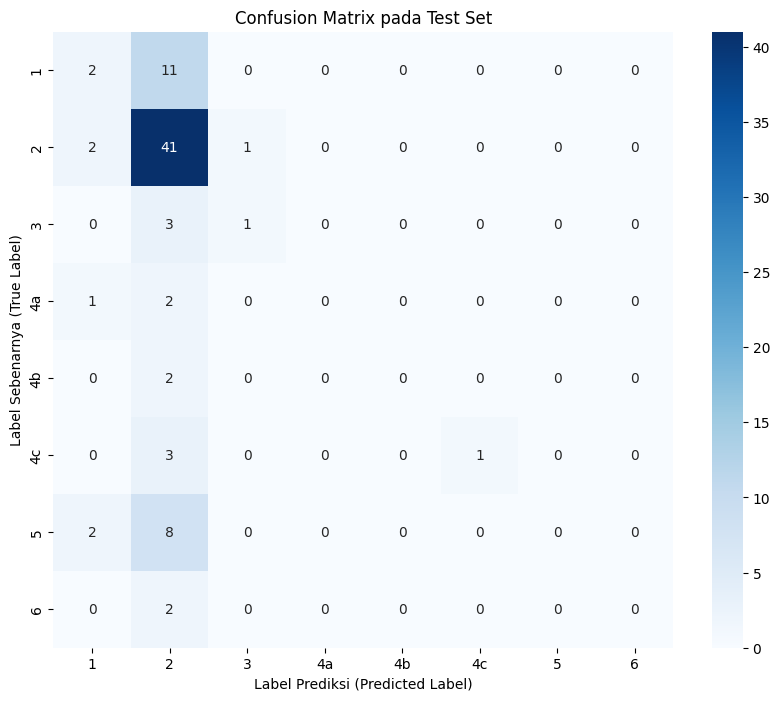

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

def evaluate_model(model, dataloader):
    """Fungsi untuk mengevaluasi model pada test set."""
    model.eval()  # Set model ke mode evaluasi
    all_labels = []
    all_preds = []

    with torch.no_grad(): # Tidak perlu menghitung gradien saat evaluasi
        for inputs, labels in tqdm(dataloader, desc="Mengevaluasi Test Set"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Fungsi untuk membuat plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix pada Test Set')
    plt.ylabel('Label Sebenarnya (True Label)')
    plt.xlabel('Label Prediksi (Predicted Label)')
    plt.show()

# --- 1. Lakukan Evaluasi pada Test Loader ---
true_labels, predicted_labels = evaluate_model(model_trained, test_loader)

# --- 2. Tampilkan Classification Report ---
# Ambil nama kelas dari label_map yang sudah kita buat
class_names = list(label_map.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names, zero_division=0)

print("\n--- Classification Report ---")
print(report)

# --- 3. Tampilkan Confusion Matrix ---
print("\n--- Confusion Matrix ---")
# Ubah label angka kembali ke label string untuk plotting
true_labels_str = [inverse_label_map[i] for i in true_labels]
predicted_labels_str = [inverse_label_map[i] for i in predicted_labels]

plot_confusion_matrix(true_labels_str, predicted_labels_str, class_names)

Evaluasi

Mengevaluasi Test Set: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]



--- Classification Report ---
              precision    recall  f1-score   support

           1       0.29      0.15      0.20        13
           2       0.57      0.93      0.71        44
           3       0.50      0.25      0.33         4
          4a       0.00      0.00      0.00         3
          4b       0.00      0.00      0.00         2
          4c       1.00      0.25      0.40         4
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2

    accuracy                           0.55        82
   macro avg       0.29      0.20      0.21        82
weighted avg       0.42      0.55      0.45        82


--- Confusion Matrix ---


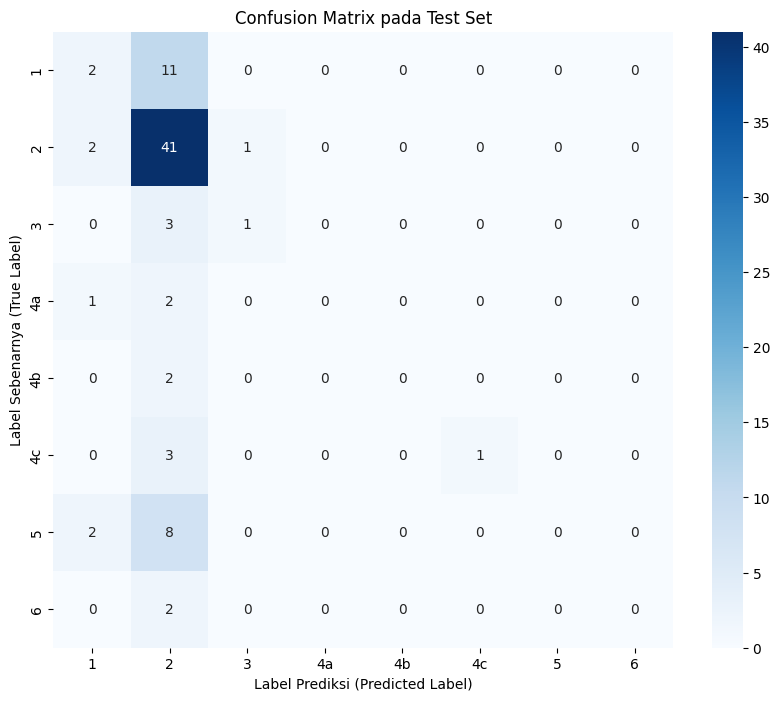

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

def evaluate_model(model, dataloader):
    """Fungsi untuk mengevaluasi model pada test set."""
    model.eval()  # Set model ke mode evaluasi
    all_labels = []
    all_preds = []

    with torch.no_grad(): # Tidak perlu menghitung gradien saat evaluasi
        for inputs, labels in tqdm(dataloader, desc="Mengevaluasi Test Set"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Fungsi untuk membuat plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix pada Test Set')
    plt.ylabel('Label Sebenarnya (True Label)')
    plt.xlabel('Label Prediksi (Predicted Label)')
    plt.show()

# --- 1. Lakukan Evaluasi pada Test Loader ---
true_labels, predicted_labels = evaluate_model(model_trained, test_loader)

# --- 2. Tampilkan Classification Report ---
# Ambil nama kelas dari label_map yang sudah kita buat
class_names = list(label_map.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names, zero_division=0)

print("\n--- Classification Report ---")
print(report)

# --- 3. Tampilkan Confusion Matrix ---
print("\n--- Confusion Matrix ---")
# Ubah label angka kembali ke label string untuk plotting
true_labels_str = [inverse_label_map[i] for i in true_labels]
predicted_labels_str = [inverse_label_map[i] for i in predicted_labels]

plot_confusion_matrix(true_labels_str, predicted_labels_str, class_names)

Menyimpan Model Terbaik

In [ ]:
# Tentukan path dan nama file untuk menyimpan model
model_save_path = "inbreast_efficientnet_b0_best.pth"

# Simpan hanya bobot (state dictionary) dari model terbaik.
# Ini adalah cara yang direkomendasikan.
torch.save(model_trained.state_dict(), model_save_path)

print(f"Model terbaik berhasil disimpan di: {model_save_path}")
print("Kamu sekarang bisa men-download file ini dari panel file Colab di sebelah kiri.")

Model terbaik berhasil disimpan di: inbreast_efficientnet_b0_best.pth
Kamu sekarang bisa men-download file ini dari panel file Colab di sebelah kiri.


# **CMMD**

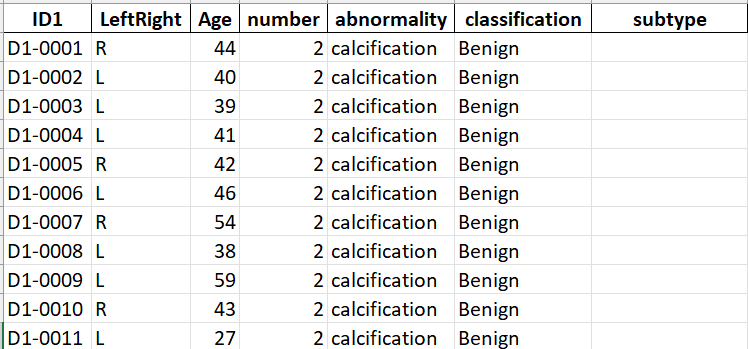

yang digunakan untuk menentukan molecular subtype adalah subset CMMD2

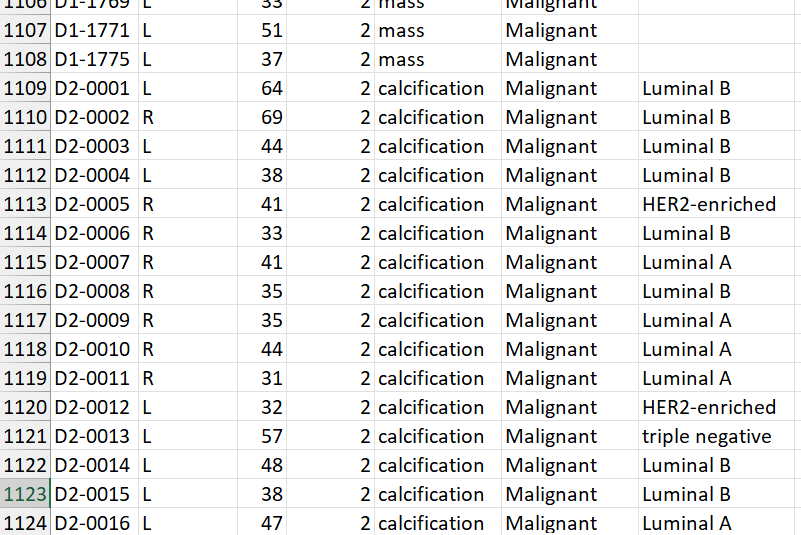

DATA LOADING

In [ ]:
import os
import gdown
import zipfile

# --- 1. Data Loading ---

# ✅ Link ZIP Dataset dari Google Drive (yang baru)
zip_url = "https://drive.google.com/uc?id=15x-kuXYSQfvwzuYei874F9_TiRVc95yt"
zip_output = "cmmd_dataset.zip"

# ✅ Link Google Sheets Clinical Data
clinical_url = "https://docs.google.com/spreadsheets/d/1cM1JgKcROmTvG3ARKkVy1jZQWM1nQ-4p/export?format=xlsx"
clinical_output = "CMMD_clinicaldata_revision.xlsx"

# --- Download ZIP Dataset ---
if not os.path.exists(zip_output):
    gdown.download(zip_url, zip_output, quiet=False)
else:
    print("File ZIP sudah ada.")

# --- Download Clinical Data (.xlsx) ---
if not os.path.exists(clinical_output):
    gdown.download(clinical_url, clinical_output, quiet=False)
else:
    print("File clinical.xlsx sudah ada.")

# --- Extract ZIP Dataset ---
extract_path = "/content/cmmd_dataset"
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_output, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print("Dataset berhasil diekstrak.")
else:
    print("Dataset sudah diekstrak sebelumnya.")


File ZIP sudah ada.
File clinical.xlsx sudah ada.
Dataset sudah diekstrak sebelumnya.


In [ ]:
import os

counter = 0
max_items = 49  # Jumlah maksimum yang ingin ditampilkan

for root, dirs, files in os.walk("/content/cmmd_dataset"):
    if counter >= max_items:
        break
    level = root.replace("/content/cmmd_dataset", "").count(os.sep)
    indent = "  " * level
    print(f"{indent}{os.path.basename(root)}/")
    counter += 1
    if counter >= max_items:
        break
    subindent = "  " * (level + 1)
    for f in files:
        if counter >= max_items:
            break
        print(f"{subindent}{f}")
        counter += 1


cmmd_dataset/
  manifest-1616439774456/
    CMMD_clinicaldata_revision.xlsx
    metadata.csv
    CMMD/
      LICENSE
      D2-0302/
        07-18-2011-NA-NA-43212/
          1.000000-NA-12980/
            1-2.dcm
            1-3.dcm
            1-1.dcm
            1-4.dcm
      D2-0466/
        07-18-2010-NA-NA-10726/
          1.000000-NA-22876/
            1-2.dcm
            1-3.dcm
            1-1.dcm
            1-4.dcm
      D2-0100/
        07-18-2011-NA-NA-01793/
          1.000000-NA-52039/
            1-2.dcm
            1-3.dcm
            1-1.dcm
            1-4.dcm
      D2-0012/
        07-18-2010-NA-NA-02689/
          1.000000-NA-46289/
            1-2.dcm
            1-3.dcm
            1-1.dcm
            1-4.dcm
      D2-0145/
        07-18-2010-NA-NA-88384/
          1.000000-NA-36820/
            1-2.dcm
            1-3.dcm
            1-1.dcm
            1-4.dcm
      D2-0400/
        07-18-2010-NA-NA-08585/
          1.000000-NA-79648/
            1-2.dcm
       

In [ ]:
import os
import pandas as pd

# --- Menampilkan isi folder ---
print("Isi folder:", os.listdir(extract_path))

# --- Load Clinical Data dari Excel ---
try:

    df = pd.read_excel(clinical_output, engine='openpyxl')
    print("5 Baris pertama dari data klinis:")
    display(df.head())
except Exception as e:
    print("Gagal membaca file Excel:", e)

# --- Filter pasien dengan ID diawali 'D2-' (CMMD2) ---
if 'ID1' in df.columns:
    df_cmmd2 = df[df['ID1'].astype(str).str.startswith('D2-')].copy()
    print("5 Baris pertama dari data CMMD2:")
    display(df_cmmd2.head())

    # Simpan ke file Excel baru
    df_cmmd2.to_excel("CMMD2_only.xlsx", index=False)
    print("Data CMMD2_only.xlsx berhasil disimpan.")
else:
    print("Kolom 'ID1' tidak ditemukan dalam data klinis.")

Isi folder: ['manifest-1616439774456']
5 Baris pertama dari data klinis:


,ID1,LeftRight,Age,number,abnormality,classification,subtype
0,D1-0001,R,44,2,calcification,Benign,NaN
1,D1-0002,L,40,2,calcification,Benign,NaN
2,D1-0003,L,39,2,calcification,Benign,NaN
3,D1-0004,L,41,2,calcification,Benign,NaN
4,D1-0005,R,42,2,calcification,Benign,NaN


5 Baris pertama dari data CMMD2:


,ID1,LeftRight,Age,number,abnormality,classification,subtype
1107,D2-0001,L,64,2,calcification,Malignant,Luminal B
1108,D2-0002,R,69,2,calcification,Malignant,Luminal B
1109,D2-0003,L,44,2,calcification,Malignant,Luminal B
1110,D2-0004,L,38,2,calcification,Malignant,Luminal B
1111,D2-0005,R,41,2,calcification,Malignant,HER2-enriched


Data CMMD2_only.xlsx berhasil disimpan.


In [ ]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872 entries, 0 to 1871
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID1             1872 non-null   object
 1   LeftRight       1872 non-null   object
 2   Age             1872 non-null   int64 
 3   number          1872 non-null   int64 
 4   abnormality     1872 non-null   object
 5   classification  1872 non-null   object
 6   subtype         749 non-null    object
dtypes: int64(2), object(5)
memory usage: 102.5+ KB


None

In [ ]:
print("Summary statistics:")
print(df_cmmd2.describe(include='all'))

Summary statistics:
            ID1 LeftRight         Age  number abnormality classification  \
count       765       765  765.000000   765.0         765            765   
unique      749         2         NaN     NaN           3              2   
top     D2-0072         L         NaN     NaN        mass      Malignant   
freq          2       395         NaN     NaN         423            753   
mean        NaN       NaN   49.783007     2.0         NaN            NaN   
std         NaN       NaN   10.807936     0.0         NaN            NaN   
min         NaN       NaN   21.000000     2.0         NaN            NaN   
25%         NaN       NaN   43.000000     2.0         NaN            NaN   
50%         NaN       NaN   49.000000     2.0         NaN            NaN   
75%         NaN       NaN   57.000000     2.0         NaN            NaN   
max         NaN       NaN   87.000000     2.0         NaN            NaN   

          subtype  
count         749  
unique          4  
top    

In [ ]:
print(df_cmmd2.isnull().sum())

ID1                0
LeftRight          0
Age                0
number             0
abnormality        0
classification     0
subtype           16
dtype: int64


In [ ]:
# --- Menampilkan jumlah nilai null di setiap kolom ---
print("Jumlah nilai null per kolom:")
print(df_cmmd2.isnull().sum())

# --- Menampilkan baris dengan subtype yang kosong ---
print("\nBaris dengan subtype yang kosong:")
display(df_cmmd2[df_cmmd2['subtype'].isnull()])

# --- Menghapus baris yang subtype-nya kosong ---
df_cmmd2 = df_cmmd2.dropna(subset=['subtype'])

# --- Mengkonfirmasi bahwa semua baris sudah memiliki subtype ---
print("\nJumlah nilai null setelah dibersihkan:")
print(df_cmmd2.isnull().sum())


Jumlah nilai null per kolom:
ID1                0
LeftRight          0
Age                0
number             0
abnormality        0
classification     0
subtype           16
dtype: int64

Baris dengan subtype yang kosong:


,ID1,LeftRight,Age,number,abnormality,classification,subtype
1133,D2-0026,R,46,2,calcification,Benign,NaN
1136,D2-0028,R,44,2,calcification,Benign,NaN
1181,D2-0072,R,40,2,calcification,Benign,NaN
1190,D2-0080,R,47,2,calcification,Benign,NaN
1200,D2-0090,L,60,2,calcification,Benign,NaN
1203,D2-0092,L,46,2,calcification,Benign,NaN
1270,D2-0158,L,61,2,both,Benign,NaN
1333,D2-0220,L,49,2,both,Malignant,NaN
1373,D2-0259,L,36,2,both,Benign,NaN
1380,D2-0265,L,27,2,both,Benign,NaN



Jumlah nilai null setelah dibersihkan:
ID1               0
LeftRight         0
Age               0
number            0
abnormality       0
classification    0
subtype           0
dtype: int64


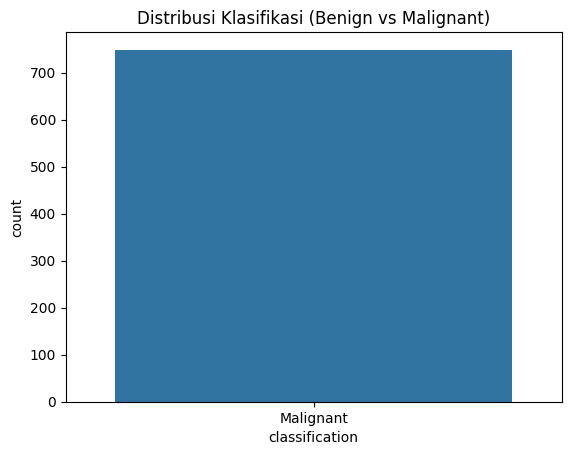

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='classification', data=df_cmmd2)
plt.title("Distribusi Klasifikasi (Benign vs Malignant)")
plt.show()


In [ ]:
df_cmmd2['classification'].value_counts(normalize=True)

,proportion
classification,
Malignant,1.0


Jika benign maka tidak ada sub-type

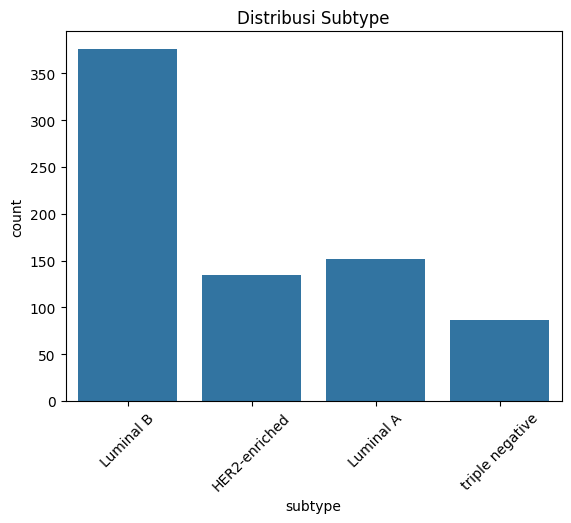

In [ ]:
sns.countplot(x='subtype', data=df_cmmd2)
plt.title("Distribusi Subtype")
plt.xticks(rotation=45)
plt.show()


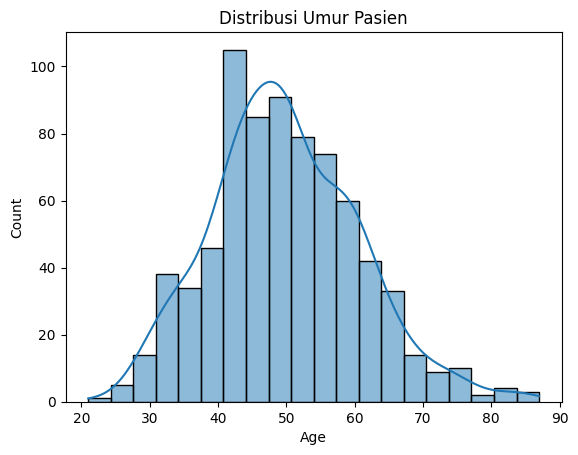

In [ ]:
sns.histplot(df_cmmd2['Age'], bins=20, kde=True)
plt.title("Distribusi Umur Pasien")
plt.xlabel("Age")
plt.show()


File DICOM ditemukan: /content/cmmd_dataset/manifest-1616439774456/CMMD/D2-0302/07-18-2011-NA-NA-43212/1.000000-NA-12980/1-2.dcm


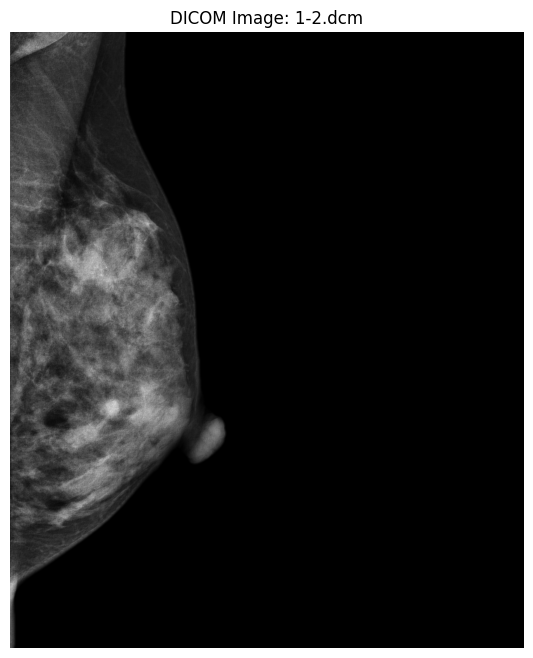

In [ ]:
!pip install pydicom
import pydicom
import matplotlib.pyplot as plt
import os

# Direktori dataset yang diekstrak
extract_path = "/content/cmmd_dataset"

# Fungsi untuk menemukan file DICOM
def find_dicom_file(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".dcm"):  # Cari file dengan ekstensi .dcm
                return os.path.join(root, file)
    return None

# Cari file DICOM pertama di direktori
dicom_file = find_dicom_file(extract_path)

if dicom_file:
    print(f"File DICOM ditemukan: {dicom_file}")

    # Baca file DICOM
    dicom_data = pydicom.dcmread(dicom_file)

    # Dapatkan array piksel dari file DICOM
    pixel_array = dicom_data.pixel_array

    # Tampilkan gambar
    plt.figure(figsize=(8, 8))
    plt.imshow(pixel_array, cmap='gray')
    plt.title(f"DICOM Image: {os.path.basename(dicom_file)}")
    plt.axis('off')
    plt.show()
else:
    print("Tidak ada file DICOM ditemukan di direktori.")

In [ ]:
import os
import numpy as np
import pandas as pd
import pydicom
import cv2
import glob
from sklearn.model_selection import train_test_split

# ✅ Path dataset dan metadata
img_dir = '/content/cmmd_dataset/manifest-1616439774456/CMMD'
meta_file = '/content/CMMD_clinicaldata_revision.xlsx'

# ✅ Load metadata
df = pd.read_excel(meta_file)

# ✅ Filter: hanya ID1 yang dimulai dengan D2-
df = df[df['ID1'].astype(str).str.startswith('D2-')]

# ✅ Drop baris dengan nilai kosong pada kolom penting
df = df.dropna(subset=['ID1', 'subtype', 'Age'])

# ✅ Label mapping
label_map = {'Luminal A': 0, 'Luminal B': 1, 'HER2-positive': 2, 'Triple-negative': 3}
df = df[df['subtype'].isin(label_map)]
df['label'] = df['subtype'].map(label_map)

# ✅ Preprocessing gambar dan metadata
images = []
metas = []
labels = []

for idx, row in df.iterrows():
    id_folder = os.path.join(img_dir, str(row['ID1']))
    dicom_candidates = glob.glob(os.path.join(id_folder, '*', '*', '*.dcm'))

    if len(dicom_candidates) == 0:
        print(f"[SKIP] Tidak ditemukan file DICOM untuk {row['ID1']}")
        continue

    dicom_file = dicom_candidates[0]

    try:
        dcm = pydicom.dcmread(dicom_file)
        img = dcm.pixel_array.astype(np.float32)

        # Resize dan normalisasi
        img = cv2.resize(img, (224, 224))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        images.append(img)

        # Metadata tambahan: Age 1 jika >=40
        age = 1 if row['Age'] >= 40 else 0
        metas.append([age])
        labels.append(row['label'])

    except Exception as e:
        print(f"❌ Error membaca {dicom_file}: {e}")

# ✅ Konversi ke array numpy
X_img = np.array(images)
X_meta = np.array(metas)
y = np.array(labels)

print(f"✅ Total gambar berhasil diproses: {len(X_img)}")

# ✅ Split data: train-test lalu train-val
X_train_img, X_test_img, X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    X_img, X_meta, y, test_size=0.2, stratify=y, random_state=42
)

X_train_img, X_val_img, X_train_meta, X_val_meta, y_train, y_val = train_test_split(
    X_train_img, X_train_meta, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# ✅ Simpan ke file .npy agar bisa dipakai lagi tanpa proses ulang
np.save('/content/X_train_images.npy', X_train_img)
np.save('/content/X_val_images.npy', X_val_img)
np.save('/content/X_test_images.npy', X_test_img)

np.save('/content/X_train_metadata.npy', X_train_meta)
np.save('/content/X_val_metadata.npy', X_val_meta)
np.save('/content/X_test_metadata.npy', X_test_meta)

np.save('/content/y_train.npy', y_train)
np.save('/content/y_val.npy', y_val)
np.save('/content/y_test.npy', y_test)

print("✅ Data berhasil disimpan ke file .npy")


✅ Total gambar berhasil diproses: 528
✅ Data berhasil disimpan ke file .npy


In [ ]:
# Load the images from the .npy file
files_path = '/content/'   #Put your own path
X_train_images = np.load(files_path+'/X_train_images.npy')
X_val_images = np.load(files_path+'/X_val_images.npy')
X_test_images = np.load(files_path+'/X_test_images.npy')

X_train_metadata = np.load(files_path+'/X_train_metadata.npy')
X_val_metadata = np.load(files_path+'/X_val_metadata.npy')
X_test_metadata = np.load(files_path+'/X_test_metadata.npy')

y_train = np.load(files_path+'/y_train.npy')
y_val = np.load(files_path+'/y_val.npy')
y_test = np.load(files_path+'/y_test.npy')

# Check the shapes
print("Shape of the train images array:", X_train_images.shape)
print("Shape of the val images array:", X_val_images.shape)
print("Shape of the test images array:", X_test_images.shape)
print("Shape of the train metadata array:", X_train_metadata.shape)
print("Shape of the val metadata array:", X_val_metadata.shape)
print("Shape of the test metadata array:", X_test_metadata.shape)
print("Shape of the train labels array:", y_train.shape)
print("Shape of the val labels array:", y_val.shape)
print("Shape of the test labels array:", y_test.shape)

Shape of the train images array: (337, 224, 224, 3)
Shape of the val images array: (85, 224, 224, 3)
Shape of the test images array: (106, 224, 224, 3)
Shape of the train metadata array: (337, 1)
Shape of the val metadata array: (85, 1)
Shape of the test metadata array: (106, 1)
Shape of the train labels array: (337,)
Shape of the val labels array: (85,)
Shape of the test labels array: (106,)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tqdm import tqdm

# Konversi label ke long tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Dataset & DataLoader
from sklearn.preprocessing import LabelEncoder

# Buat dan fit encoder
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

# Konversi ke tensor
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_enc, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)

# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

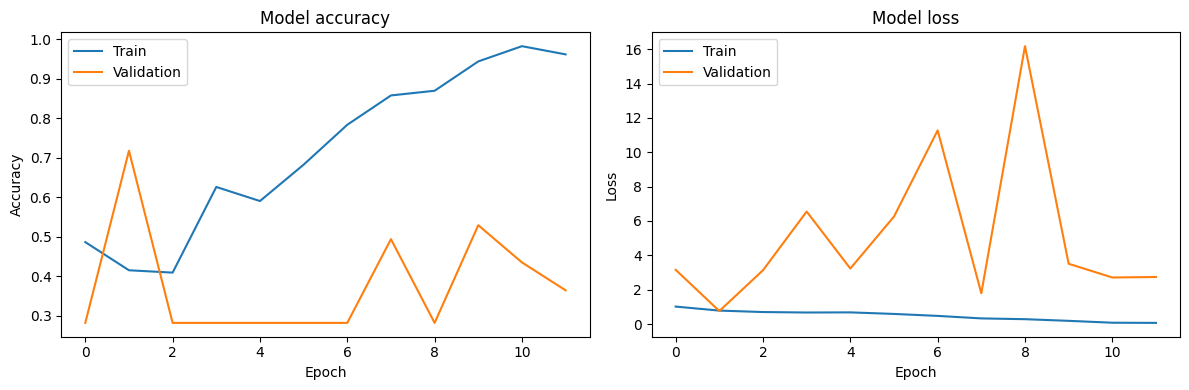

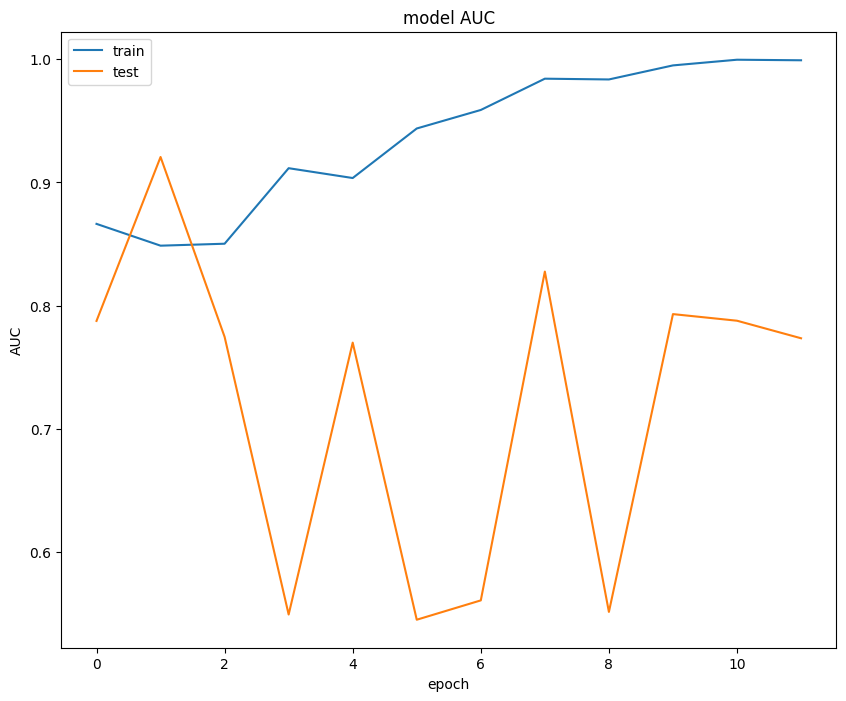

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


#Plot AUC figureearl
plt.figure(figsize=(10,8))
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
!pip install timm
import timm

metadata_dim = X_train_metadata.shape[1]
num_classes = len(np.unique(y_train_enc))


class FusionXceptionModel(nn.Module):
    def __init__(self, num_classes, metadata_dim):
        super(FusionXceptionModel, self).__init__()
        # Pretrained Xception from timm
        self.backbone = timm.create_model('xception', pretrained=True, num_classes=0)  # exclude final layer
        self.backbone.requires_grad_(True)  # unfreeze
        self.img_fc = nn.Sequential(
            nn.Linear(self.backbone.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.meta_fc = nn.Sequential(
            nn.Linear(metadata_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.combined_fc = nn.Sequential(
            nn.Linear(512 + 32, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, metadata):
        x_img = self.backbone(image)  # (B, features)
        x_img = self.img_fc(x_img)
        x_meta = self.meta_fc(metadata)
        x = torch.cat((x_img, x_meta), dim=1)
        return self.combined_fc(x)
model = FusionXceptionModel(num_classes, metadata_dim).to(device)


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [ ]:
import timm
import torch.nn as nn
import torch

class FusionEfficientNetB0(nn.Module):
    def __init__(self, num_classes=5, metadata_dim=10):  # Ganti metadata_dim sesuai jumlah fitur CMMD
        super(FusionEfficientNetB0, self).__init__()
        self.image_model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=0)
        self.metadata_net = nn.Sequential(
            nn.Linear(metadata_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.combined_fc = nn.Sequential(
            nn.Linear(self.image_model.num_features + 32, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, metadata):
        x_img = self.image_model(image)
        x_meta = self.metadata_net(metadata)
        x = torch.cat((x_img, x_meta), dim=1)
        return self.combined_fc(x)


In [ ]:
# Inisialisasi model CMMD (dengan metadata)
metadata_dim = X_train_metadata.shape[1]  # Ganti sesuai dimensi metadata kamu
model = FusionEfficientNetB0(num_classes=5, metadata_dim=metadata_dim).to(device)

# Load weight EfficientNet dari INbreast
inbreast_weights = torch.load("inbreast_efficientnet_b0_best.pth", map_location=device)

# Ambil bobot pretrained INbreast dan simpan ke image_model
image_model_dict = model.image_model.state_dict()
filtered_weights = {k: v for k, v in inbreast_weights.items() if k in image_model_dict and v.shape == image_model_dict[k].shape}

# Update image_model dengan bobot pretrained dari INbreast
image_model_dict.update(filtered_weights)
model.image_model.load_state_dict(image_model_dict)



<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import timm

class FusionEfficientNetB0(nn.Module):
    def __init__(self, num_classes=5, metadata_dim=10):  # Sesuaikan metadata_dim
        super(FusionEfficientNetB0, self).__init__()
        self.image_model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=0)
        self.metadata_net = nn.Sequential(
            nn.Linear(metadata_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.combined_fc = nn.Sequential(
            nn.Linear(self.image_model.num_features + 32, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, metadata):
        x_img = self.image_model(image)
        x_meta = self.metadata_net(metadata)
        x = torch.cat((x_img, x_meta), dim=1)
        return self.combined_fc(x)


In [ ]:
# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inisialisasi model CMMD
metadata_dim = X_train_metadata.shape[1]  # Sesuaikan dengan datamu
model = FusionEfficientNetB0(num_classes=5, metadata_dim=metadata_dim).to(device)

# Load bobot EfficientNet dari INbreast
inbreast_weights = torch.load("inbreast_efficientnet_b0_best.pth", map_location=device)

# Ambil hanya bobot yang cocok untuk image_model
image_model_dict = model.image_model.state_dict()
filtered_weights = {k: v for k, v in inbreast_weights.items() if k in image_model_dict and v.shape == image_model_dict[k].shape}

# Update backbone dengan bobot dari INbreast
image_model_dict.update(filtered_weights)
model.image_model.load_state_dict(image_model_dict)

print("✅ Bobot dari model INbreast berhasil dimuat ke image_model CMMD!")


✅ Bobot dari model INbreast berhasil dimuat ke image_model CMMD!


In [ ]:
for param in model.image_model.parameters():
    param.requires_grad = False


In [ ]:
# Loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


In [ ]:
from torchvision import transforms
from PIL import Image
import torch

# Preprocessing untuk gambar
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Mapping kelas ke rekomendasi obat
recommendation_map = {
    0: "BI-RADS 1: Tidak perlu pengobatan, lakukan screening rutin.",
    1: "BI-RADS 2: Jinak. Observasi berkala.",
    2: "BI-RADS 3: Kemungkinan jinak. Follow-up 6 bulan.",
    3: "BI-RADS 4: Curiga kanker. Perlu biopsi.",
    4: "BI-RADS 5: Sangat curiga kanker. Biopsi dan kemungkinan kemoterapi.",
}

# Fungsi prediksi
def predict_and_recommend(model, image_path, metadata_tensor, device):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = image_transform(image).unsqueeze(0).to(device)
    metadata_tensor = metadata_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor, metadata_tensor)
        _, predicted_class = torch.max(output, 1)
        prediction = predicted_class.item()

    recommendation = recommendation_map.get(prediction, "Tidak ada rekomendasi.")
    return prediction, recommendation


In [ ]:
import torch
import torch.nn as nn
import timm

class FusionEfficientNetB0(nn.Module):
    def __init__(self, num_classes=4, metadata_dim=10):  # 4 subtipe: Luminal A, Luminal B, HER2, TNBC
        super(FusionEfficientNetB0, self).__init__()
        self.image_model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=0)
        self.metadata_net = nn.Sequential(
            nn.Linear(metadata_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.combined_fc = nn.Sequential(
            nn.Linear(self.image_model.num_features + 32, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, metadata):
        x_img = self.image_model(image)
        x_meta = self.metadata_net(metadata)
        x = torch.cat((x_img, x_meta), dim=1)
        return self.combined_fc(x)


In [ ]:
def get_treatment_recommendation(subtype: str) -> str:
    if subtype == "Luminal A":
        return (
            "1. Terapi hormonal utama (Tamoxifen atau Inhibitor Aromatase selama 5-10 tahun)\n"
            "2. Operasi (lumpektomi atau mastektomi)\n"
            "3. Radioterapi\n"
            "4. Kemoterapi hanya jika tumor besar atau genomik mendukung"
        )
    elif subtype == "Luminal B":
        return (
            "1. Kemoterapi hampir selalu diperlukan (neoadjuvan atau adjuvan)\n"
            "2. Terapi hormonal setelah kemo\n"
            "3. Tambahan terapi target anti-HER2 jika HER2+\n"
            "4. Operasi dan radioterapi"
        )
    elif subtype == "HER2-Enriched":
        return (
            "1. Terapi target anti-HER2 (Trastuzumab, Pertuzumab)\n"
            "2. Kemoterapi\n"
            "3. Operasi dan radioterapi\n"
            "4. Terapi hormonal jika HR+"
        )
    elif subtype == "Triple Negative":
        return (
            "1. Kemoterapi sebagai pengobatan utama\n"
            "2. Imunoterapi (jika PD-L1+)\n"
            "3. Inhibitor PARP (jika BRCA mutasi)\n"
            "4. Operasi dan radioterapi"
        )
    else:
        return "Tidak ada rekomendasi: subtipe tidak dikenali."

# Mapping indeks output ke nama subtipe
subtype_labels = ["Luminal A", "Luminal B", "HER2-Enriched", "Triple Negative"]

def classify_and_recommend(image_tensor, metadata_tensor, model, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        metadata_tensor = metadata_tensor.to(device)
        output = model(image_tensor, metadata_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        subtype = subtype_labels[predicted_class]
        recommendation = get_treatment_recommendation(subtype)
        return subtype, recommendation


In [ ]:
def full_breast_cancer_pipeline(image_path, metadata_tensor,
                                 birads_model, subtype_model, device):
    # --- Preprocessing Gambar ---
    image = Image.open(image_path).convert("RGB")
    image_tensor = image_transform(image).unsqueeze(0).to(device)
    metadata_tensor = metadata_tensor.unsqueeze(0).to(device)

    # --- Stage 1: Prediksi BI-RADS ---
    birads_model.eval()
    with torch.no_grad():
        output_birads = birads_model(image_tensor)
        birads_pred = torch.argmax(output_birads, dim=1).item()

    # --- Cek apakah lanjut ke subtyping ---
    if birads_pred < 3:  # Bisa disesuaikan jadi <4
        return {
            "birads_class": birads_pred,
            "subtype": None,
            "treatment": recommendation_map.get(birads_pred)
        }

    # --- Stage 2: Prediksi Subtype ---
    subtype_model.eval()
    with torch.no_grad():
        subtype_output = subtype_model(image_tensor, metadata_tensor)
        subtype_idx = torch.argmax(subtype_output, dim=1).item()
        subtype_label = subtype_labels[subtype_idx]
        treatment = get_treatment_recommendation(subtype_label)

    return {
        "birads_class": birads_pred,
        "subtype": subtype_label,
        "treatment": treatment
    }


In [ ]:
import gradio as gr

def gui_predict(image_file, age):
    metadata_tensor = torch.tensor([[1 if age >= 40 else 0]], dtype=torch.float32)
    results = full_breast_cancer_pipeline(image_file.name, metadata_tensor,
                                          birads_model, subtype_model, device)

    response = f"### Hasil Klasifikasi:\n"
    response += f"- **BI-RADS:** {results['birads_class']}\n"
    if results['subtype']:
        response += f"- **Subtipe Molekuler:** {results['subtype']}\n"
        response += f"### Rekomendasi Terapi:\n{results['treatment']}"
    else:
        response += f"### Rekomendasi:\n{results['treatment']}"
    return response

interface = gr.Interface(
    fn=gui_predict,
    inputs=[gr.Image(type="filepath"), gr.Number(label="Umur Pasien")],
    outputs="markdown"
)
interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fa1fb830cf01b1db9c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
